In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

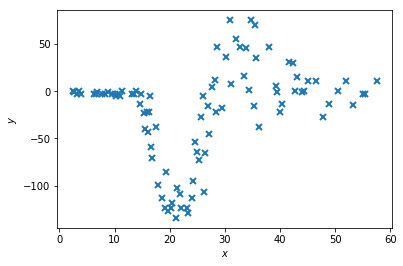

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = gpflow.kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale(Xnorm, Y[:,None], k1, nonstat)

In [4]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 1.],None,+ve
adaptive_lengthscale_gp.kern1.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.likelihood.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.nonstat.signal_variance,[ 1.],None,+ve


In [5]:
m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance.prior = gpflow.priors.Gamma(1.,1.)

#m.kern1.lengthscales = 1.
#m.kern1.lengthscales.fixed = True
#m.kern1.variance = 1.
#m.kern1.variance.fixed = True

m.likelihood.variance.prior = gpflow.priors.Gamma(1.,1.)
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1.,1.)
#m.nonstat.signal_variance = 1
#m.nonstat.signal_variance.fixed = True
#m.likelihood.variance = 1
#m.likelihood.variance.fixed = True

In [21]:
m.optimize(maxiter=50000) # start near MAP

      fun: array([ 685.92699719])
 hess_inv: <192x192 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.77860118e+01,  -5.74128555e+00,  -9.42516265e-01,
        -9.05761706e-02,  -3.45178952e+00,   1.75388839e+00,
        -9.96265123e-01,  -1.21736160e+00,  -3.59314927e+01,
         1.51766419e+00,   1.88694967e-01,  -2.85352166e+01,
         2.02054513e+01,   3.43261490e+00,  -2.56494248e+01,
         2.44217300e+01,  -1.12258581e+00,  -6.56409304e-01,
        -3.58779150e-01,   2.53618709e-01,  -3.58066696e+00,
         2.41697238e+00,   2.92469695e+00,   2.72245673e+01,
        -3.61176150e+00,  -1.82368815e+01,   4.57351958e+00,
         1.34285063e+00,  -3.36963572e+00,  -1.46643228e+01,
        -8.41617266e+00,   2.15076971e+01,   3.47902508e-01,
        -3.54049612e+01,   1.94917639e+00,   3.82396152e+00,
         5.63233404e+01,   3.53023447e+01,  -1.84568556e+01,
         4.37304695e+01,  -3.44420415e+01,  -4.59239140e+01,
         2.66787187e+00,   1.02379118e+01

In [7]:
samples = m.sample(500, verbose=True, epsilon=0.0005, thin = 2, burn = 500, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  85.0 %
Iteration:  200 	 Acc Rate:  98.0 %
Iteration:  300 	 Acc Rate:  97.0 %
Iteration:  400 	 Acc Rate:  97.0 %
Iteration:  500 	 Acc Rate:  99.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  97.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %


In [8]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[-0.56350333] [ 0.49066333] [-0.50469424] [ 0.56326446] [ 0.6078121 ] [ 0.43133005] [-0.2180089 ] [-0.06875073] [ 0.011268 ] [-0.18538969] [ 0.04735166] [-0.19002712] [-0.19213034] [ 0.69043579] [-0.19644091] [-0.19867502] [ 0.82997702] [ 0.82292631] [-0.21384368] [ 0.72238552] [ 0.55840034] [ 0.66566217] [ 0.31332773] [ 0.12012882] [ 0.30715666] [ 0.12287168] [ 0.30064848] [ 0.62944907] [-0.2348119 ] [-0.23649538] [ 0.13609862] [-0.26913201] [-0.25542319] [-0.26853506] [-0.08977874] [-0.27872255] [-0.28808237] [-0.29457981] [-0.31435151] [-0.15614784] [-0.20322938] [-0.32454613] [-0.33808239] [-0.33749446] [-0.31099938] [-0.22769084] [ 0.02123268] [-0.06311658] [-0.16523423] [ 0.24042408] [ 0.62937646] [-0.26254534] [-0.25037096] [ 0.36483736] [-0.20208531] [ 0.82647062] [-0.85815296] [-0.23859006] [-1.04882352] [-0.13342292] [-0.50519746] [-0.45834238] [-0.15100176] [-0.41538938] [-0.30723063] [-0.09921409] [-0.23556773] [-0.00656824] [-0.33050155] [ 0.11721067] [-0.29765977] [-0.13183335] [ 0.24120391] [-0.22055005] [ 0.05039757] [ 0.09207519] [ 0.2934974 ] [ 0.20125527] [-0.12007669] [-0.10241034] [ 0.12082445] [ 0.02125367] [ 0.13673216] [ 0.13032914] [ 0.05865031] [-0.09706755] [ 0.35342575] [ 0.47012663] [ 0.16469167] [ 0.05932158] [-0.24855595] [-0.09663247] [ 0.24189991] [ 0.10447719]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[ 5.41502278e-01] [ -1.07277217e+00] [ 3.91421912e-01] [ 1.04623370e+00] [ -2.71579665e-01] [ -2.72017659e+00] [ 2.91773333e+00] [ -5.01063548e+00] [ -1.13736275e+01] [ 1.52735827e+00] [ 2.02649181e+00] [ -2.28679499e+00] [ -2.76350592e+00] [ -1.94942964e+00] [ -2.63381183e+00] [ -1.84383458e+00] [ 8.38656133e-01] [ 7.26427248e-01] [ -4.88166986e+00] [ 7.06588337e-01] [ -1.94465886e-01] [ 1.00314964e+00] [ -1.80257438e-01] [ -1.79567057e+00] [ 2.88014472e-01] [ 8.89493476e-01] [ 1.75174777e-01] [ 4.99860643e-01] [ -3.00082207e+00] [ -2.58051398e+00] [ 1.19104629e+00] [ 6.05226836e+00] [ -7.65668894e-01] [ 1.82740712e+00] [ -1.15720773e+00] [ 8.86939145e-01] [ 8.67959555e-01] [ 6.87324441e-01] [ 3.55323044e-01] [ -9.49995387e-01] [ -4.28160984e-01] [ -1.08312393e-01] [ -3.32700119e-01] [ -2.34959193e-01] [ -2.48259010e-01] [ -2.27196386e-02] [ 4.53956105e-01] [ 2.12789709e-01] [ -1.00354600e-01] [ 1.90613101e-02] [ -2.35769354e-01] [ -2.29773989e-02] [ -1.84360480e-01] [ -1.47348756e-01] [ -1.44046633e-01] [ -1.43737932e-01] [ 1.17866735e+00] [ -1.36922048e-02] [ 1.96043118e+00] [ 4.51288136e-02] [ 3.85307686e-01] [ 3.13270640e-01] [ -1.55690845e-01] [ -4.22543560e-04] [ 1.73821549e-01] [ -1.23764280e-01] [ 1.22257656e-01] [ -1.45810703e-01] [ 1.05753553e-01] [ -2.00162161e-01] [ 1.08858193e-01] [ 1.86823259e-02] [ -6.24857969e-02] [ -1.30890988e-01] [ -6.17619743e-02] [ -2.58355513e-02] [ -2.97572922e-02] [ -1.92366817e-02] [ 2.98061659e-02] [ -1.89812432e-02] [ -1.05039782e-02] [ -1.10586252e-02] [ -1.55488234e-02] [ -8.20071936e-03] [ 1.51483761e-02] [ 6.64030437e-03] [ -3.49598127e-03] [ -1.47778188e-03] [ 5.34239493e-02] [ -7.01708694e-03] [ -6.08529538e-02] [ -4.23589703e-03] [ -3.95861334e-04] [ 2.73157272e-03]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 1.75161482e-05],"Ga([ 1.],[ 1.])",+ve
adaptive_lengthscale_gp.kern1.variance,[ 11.99192087],"Ga([ 1.],[ 1.])",+ve
adaptive_lengthscale_gp.likelihood.variance,[ 73.2523236],"Ga([ 1.],[ 1.])",+ve
adaptive_lengthscale_gp.nonstat.signal_variance,[ 60.36224124],"Ga([ 1.],[ 1.])",+ve


In [9]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv

In [10]:
sample_df = m.get_samples_df(samples)

In [11]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [12]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [13]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [14]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [15]:
LowerL

array([[ 0.00162387,  0.00162387,  0.00162387, ...,  0.00162387,
         0.00162387,  0.00162387],
       [ 0.00160696,  0.00160696,  0.00160696, ...,  0.00160696,
         0.00160696,  0.00160696],
       [ 0.0016422 ,  0.0016422 ,  0.0016422 , ...,  0.0016422 ,
         0.0016422 ,  0.0016422 ],
       ..., 
       [ 0.04069014,  0.04069014,  0.04069014, ...,  0.04069014,
         0.04069014,  0.04069014],
       [ 0.03926819,  0.03926819,  0.03926819, ...,  0.03926819,
         0.03926819,  0.03926819],
       [ 0.03821221,  0.03821221,  0.03821221, ...,  0.03821221,
         0.03821221,  0.03821221]])

In [16]:
mean_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:,0]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)

sig_samples = m.nonstat.signal_variance.get_samples_df(samples)
noise_samples = m.likelihood.variance.get_samples_df(samples)
signal_var = np.array([])
noise_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

for n in noise_samples:
    noise_var = np.append(noise_var, n)
    

In [17]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Std_noise = np.sqrt(noise_var)
    signal_std = np.sqrt(signal_var)
 
    Stdgrid = np.sqrt(Vargrid)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    lower1 = lower - 2*Std_noise
    upper1 = upper + 2*Std_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

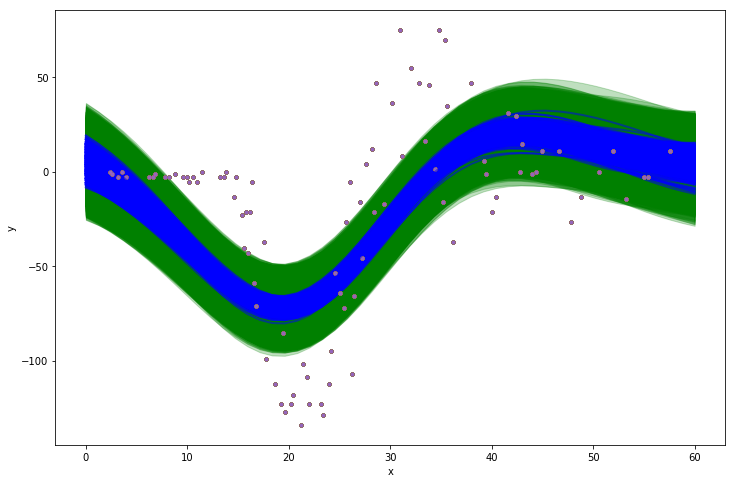

In [18]:
mini = 5
maxi = 500
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var[i])  

In [19]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

IndexError: index 500 is out of bounds for axis 0 with size 500

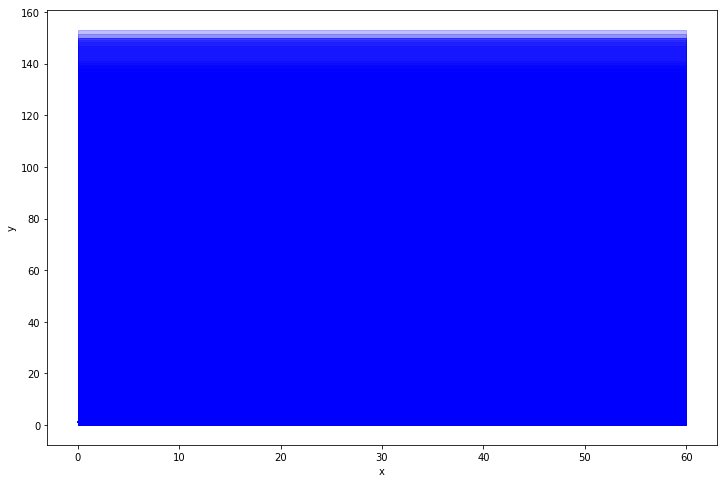

In [20]:
mini = 205
maxi = 1500
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [ ]:
m